<a href="https://colab.research.google.com/github/ElPapi42/AgeClassifier/blob/master/AgeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tqdm
!pip install --upgrade pillow
!pip install git+https://github.com/Jwink3101/parmapper
clear_output()

In [0]:
#Imports.
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from parmapper import parmap
import sys
import pathlib

## Data Download

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import tarfile
import requests
from tqdm import tqdm

folder_path = "./Datasets"

wiki_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar"
wiki_path = folder_path + '/wiki.tar.gz'

imdb_url = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"
imdb_path = folder_path + '/imdb.tar.gz'

#Create Dataset folder if not exists
if(not os.path.exists(folder_path)):
  os.mkdir(folder_path)

#download wikipedia faces dataset
if(not(os.path.exists(wiki_path) and os.path.isfile(wiki_path))):
  resp = requests.get(wiki_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(wiki_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Wiki Faces Download Error")

#download imdb faces dataset
if(not(os.path.exists(imdb_path) and os.path.isfile(imdb_path))):
  resp = requests.get(imdb_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(imdb_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Imdb Faces Download Error")

In [0]:
#Extract Datasets

#Wikipedia Dataset
tar = tarfile.open(wiki_path, "r")
tar.extractall(folder_path)
tar.close()
os.remove("./Datasets/wiki_crop/wiki.mat")

#IMDB Dataset
tar = tarfile.open(imdb_path, "r")
tar.extractall(folder_path)
tar.close()
os.remove("./Datasets/imdb_crop/imdb.mat")

In [0]:
#Find urls
root = "./Datasets"
folders = os.listdir(root)
urls = list()

if(not ("dataset.csv" in folders)):

  folders.remove("imdb.tar.gz")
  folders.remove("wiki.tar.gz")

  for folder in folders:
    subfolders = os.listdir("{root}/{folder}".format(root=root, folder=folder))
    for subfolder in subfolders:
      files = os.listdir("{root}/{folder}/{subfolder}".format(root=root, folder=folder, subfolder=subfolder))
      for file in files:
        path = "{root}/{folder}/{subfolder}/{file}".format(root=root, folder=folder, subfolder=subfolder, file=file)
        urls.append(path)

In [6]:
def preproc(filepath):
  try:
    #Check if the image is corrupted
    Image.open(filepath)

    filename = filepath[:-4].split("/")[-1]
    folder = filepath[:-4].split("/")[1]
    file_data = filename.split("_")

    if(folder == "wiki_crop"):
      id = "w" + file_data[0]
      born = int(file_data[1].split("-")[0])
    else:
      id = "i" + file_data[0][2:]
      born = int(file_data[2].split("-")[0])

    taken = int(file_data[-1])
    age = taken - born
    age = str(age)

    return [id, age, filepath]
  except OSError:
    #os.remove(filepath)
    return [None, None, None]

if(not ("dataset.csv" in folders)):
  #Extract ids and age from images file names
  processed = list(parmap(preproc, urls, progress=True))
  faces_df = pd.DataFrame(processed, columns=["id", "age", "url"])
  faces_df.to_csv(root + "/dataset.csv", index=False)

100%|██████████| 523051/523051 [05:32<00:00, 1570.76it/s]


## Exploratory Data analysis and Cleaning

In [7]:
#Load csv
faces_df = pd.read_csv("./Datasets/dataset.csv")

#Shuffle
faces_df = faces_df.sample(frac=1.0)
faces_df.head()

,id,age,url
304953,i0010075,27,./Datasets/imdb_crop/75/nm0010075_rm2514063104...
232305,i1423955,21,./Datasets/imdb_crop/55/nm1423955_rm1117777920...
240686,i0597480,25,./Datasets/imdb_crop/80/nm0597480_rm2820774656...
167908,i2210709,38,./Datasets/imdb_crop/09/nm2210709_rm2155593728...
88534,i0001353,70,./Datasets/imdb_crop/53/nm0001353_rm3439174144...


In [8]:
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523051 entries, 304953 to 192459
Data columns (total 3 columns):
id     523051 non-null object
age    523051 non-null int64
url    523051 non-null object
dtypes: int64(1), object(2)
memory usage: 16.0+ MB


In [10]:
#Double check for null datapoints
faces_df.isnull().sum()

id     0
age    0
url    0
dtype: int64

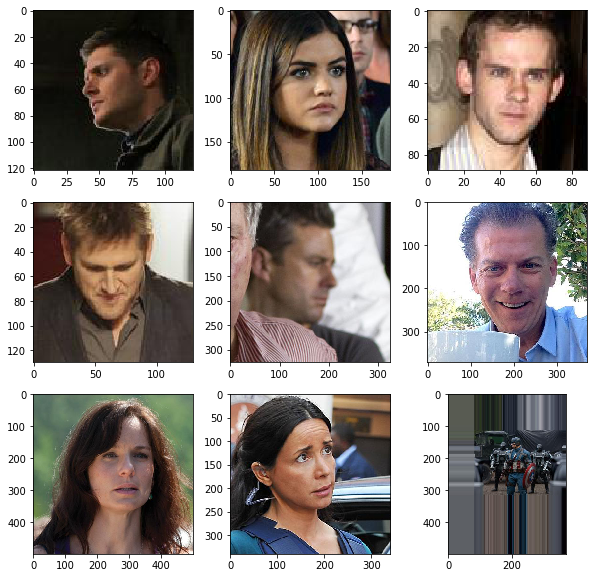

In [9]:
#Lets see some examples
plt.figure(figsize=(10,10))
for i, path in enumerate(faces_df["url"].iloc[:9]):
    img = tf.keras.preprocessing.image.load_img(path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()

In [11]:
#Check descriptive statistics
faces_df.describe()

,age
count,523051.000000
mean,32.978163
std,35.476414
min,-30.000000
25%,24.000000
50%,33.000000
75%,43.000000
max,2015.000000


High Precense of outliers, lets fix that

In [12]:
#Clear Dataset from outliers
age_up_0 = faces_df["age"] > 0
age_down_75 = faces_df["age"] < 75
faces_df = faces_df[age_up_0 & age_down_75]
faces_df.describe()

,age
count,455428.000000
mean,36.501787
std,12.437170
min,1.000000
25%,28.000000
50%,35.000000
75%,44.000000
max,74.000000


In [15]:
#Check for how much unique people is here
id_count = faces_df["id"].nunique()
"The Dataset contains {count} unique persons across its images".format(count=id_count)

'The Dataset contains 19956 unique persons across its images'

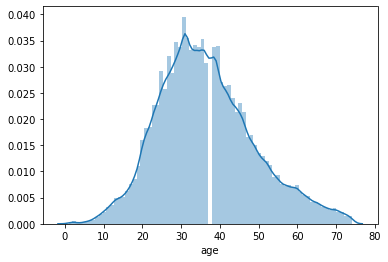

In [16]:
#Lets see the distribution of the age across our dataset
sns.distplot(faces_df["age"], bins=75)

## Dataset Preparation

In [0]:
#Split dataset between train, eval and test
full_df = faces_df
eval_df = full_df.sample(frac=0.05)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.05)
train_df = full_df.drop(test_df.index)

In [18]:
#Store number of datapoints in each dataset
train_count = train_df.shape[0]
eval_count = eval_df.shape[0]
test_count = test_df.shape[0]
print("Train samples: " + str(train_count))
print("Evaluation samples: " + str(eval_count))
print("Test samples: " + str(test_count))

Train samples: 411024
Evaluation samples: 22771
Test samples: 21633


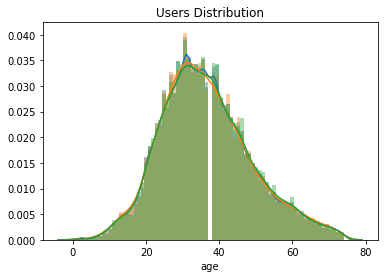

In [19]:
#Verify the distribution of the three splits
sns.distplot(a=train_df["age"], bins=75).set_title("Users Distribution")
sns.distplot(a=eval_df["age"], bins=75)
sns.distplot(a=test_df["age"], bins=75)

plt.show()

## Dataset Creation

In [0]:
#Generator funcion
tf.train.

In [0]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices().shuffle(4196)
eval_ds = tf.data.Dataset.from_tensor_slices().batch(eval_count)
test_ds = tf.data.Dataset.from_tensor_slices().batch(test_count)